https://www.istat.it/it/archivio/243332

http://dati.istat.it/Index.aspx?QueryId=19101#

http://amisuradicomune.istat.it/aMisuraDiComune/

Dati Strade ANAS:
http://dati.mit.gov.it/catalog/dataset/grafo-stradale-anas/resource/18a67a49-63d5-44f6-805b-f0793e70d6b1

Due liste, una con postazioni (lat-long) e l'altra con # dei passaggi giornalieri

https://www.stradeanas.it/sites/default/files/pdf/Lista%20postazioni.pdf

https://www.stradeanas.it/sites/default/files/pdf/Anas%20Dati%20TGMA%202019.pdf

Proviamo a estrarre dei dataframe da queste, dopodichè filtriamo e andiamo a vedere dove sarebbero posizionati i nodi 
nella rete di riferimento. 
Idealmente pensiamo a come utilizzare queste informazioni per mettere giù i pesi della rete dei comuni


In [9]:
#!pip install geopandas
#!git clone https://github.com/openpolis/geojson-italy.git

In [313]:
from descartes import PolygonPatch
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from datetime import datetime 
import os 
import networkx as nx
import scipy
#from google.colab import files
%matplotlib notebook 

import warnings
warnings.filterwarnings('ignore')

In [115]:
Istat_Munic = pd.read_csv("comuni_final.csv")
Istat_Munic = Istat_Munic.rename(columns={"Denominazione":"name", "Codice comune":"com_istat_code_num"})

In [116]:
OP_Munic = gpd.read_file("geojson-italy/geojson/limits_IT_municipalities.geojson")

ERROR:fiona._env:Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.


In [117]:
Istat_Munic.head()

,Unnamed: 0,com_istat_code_num,name,Totale Maschi,Totale Femmine,Totale Abitanti
0,101,1001,Agliè,1237,1398,2635
1,203,1002,Airasca,1873,1808,3681
2,305,1003,Ala di Stura,238,215,453
3,407,1004,Albiano d'Ivrea,808,838,1646
4,509,1006,Almese,3121,3257,6378


In [118]:
OP_Munic.drop(OP_Munic.columns.difference(['name', 'prov_name', 'reg_name', 'com_istat_code_num', 'geometry']), 1, inplace=True)

In [119]:
len(Istat_Munic) - len(OP_Munic) #Minor issue

12

In [132]:
final_data = OP_Munic.merge(Istat_Munic, on = "name" , how = "inner")

In [133]:
final_data.drop(final_data.columns.difference(['name', 'Totale Maschi', 'Totale Femmine', 'Totale Abitanti', 'prov_name', 'reg_name', 'geometry']), 1, inplace=True)
final_data = final_data.rename(columns = {"Totale Maschi":"males", "Totale Femmine":"females", "Totale Abitanti":"total"})

In [134]:
final_data["id"] = final_data.index
#Moving last column as first 
cols = list(final_data.columns)
cols = [cols[-1]] + cols[:-1]
final_data = final_data[cols]

In [135]:
""" #Be careful, it takes 6 mins
final_data["neighbors_name"] = None  # add neighbors name column

for index, munic in tqdm(final_data.iterrows(), total = len(final_data)):   
    # get 'not disjoint' munic
    neighbors = final_data[~final_data.geometry.disjoint(munic.geometry)].name.tolist()
    # remove own name from the list
    neighbors = [ name for name in neighbors if munic.name != name ]
    # add names of neighbors as NEIGHBORS value
    final_data.at[index, "neighbors_name"] = ", ".join(neighbors)
    
    """

In [142]:
# Be careful, it takes 6 mins
final_data["neighbors_id"] = None  # add neighbors id column

for index, munic in tqdm(final_data.iterrows(), total = len(final_data)):   
    # get 'not disjoint' munic
    neighbors = final_data[~final_data.geometry.disjoint(munic.geometry)].id.tolist()
    # remove own id from the list
    neighbors = [ id for id in neighbors if munic.id != id ]
    # add ids of neighbors as NEIGHBORS value
    final_data.at[index, "neighbors_id"] = ", ".join(str(neighbors))

In [217]:
def clean_neigh_id_list(neigh_list):
    
    empty = []
    
    neigh_list= neigh_list.replace(",,", "-")
    neigh_list= neigh_list.replace(",", "")
    neigh_list= neigh_list.replace(" ", "")
    neigh_list= neigh_list.replace("-"," ")
    neigh_list= neigh_list.replace(" ",", ")
    neigh_list = neigh_list.strip('][').split(', ')
    
    if neigh_list[0] != "":
        clean_list = [int(s) for s in neigh_list]
    else:
        clean_list = empty
    return clean_list
    

In [218]:
final_data["neighbors_id"] = final_data["neighbors_id"].apply(lambda x: clean_neigh_id_list(x))
#POINT(x,y) --> (Long, Lat)
final_data["latitude"] = final_data.geometry.centroid.y
final_data["longitude"] = final_data.geometry.centroid.x

In [231]:
final_data.head()

,id,name,prov_name,reg_name,geometry,males,females,total,neighbors_name,neighbors_id,latitude,longitude
0,0,Agliè,Torino,Piemonte,"MULTIPOLYGON (((7.78266 45.38717, 7.79106 45.3...",1237,1398,2635,"Agliè, Bairo, Cuceglio, Ozegna, San Giorgio Ca...","[13, 94, 172, 242, 245, 272, 293]",45.365909,7.775987
1,1,Airasca,Torino,Piemonte,"MULTIPOLYGON (((7.48795 44.93917, 7.49307 44.9...",1873,1808,3681,"Airasca, Cumiana, None, Piscina, Scalenghe, Vo...","[95, 164, 190, 258, 311]",44.921764,7.483506
2,2,Ala di Stura,Torino,Piemonte,"MULTIPOLYGON (((7.27324 45.33927, 7.27360 45.3...",238,215,453,"Ala di Stura, Balme, Ceres, Chialamberto, Gros...","[17, 70, 73, 116, 129, 148]",45.306808,7.282044
3,3,Albiano d'Ivrea,Torino,Piemonte,"MULTIPOLYGON (((7.92507 45.44821, 7.92682 45.4...",808,838,1646,"Albiano d'Ivrea, Azeglio, Bollengo, Caravino, ...","[12, 25, 54, 123, 173, 191, 292]",45.431591,7.943660
4,4,Almese,Torino,Piemonte,"MULTIPOLYGON (((7.43490 45.13442, 7.43524 45.1...",3121,3257,6378,"Almese, Avigliana, Caselette, Rubiana, Val del...","[11, 60, 224, 281, 299]",45.118006,7.420164


## Network

In [239]:
# Creating dict of lists for network instancing
dol = pd.Series(final_data.neighbors_id, index = final_data.id).to_dict()

In [241]:
graph = nx.from_dict_of_lists(dol)

In [251]:
def mergeDict(dict1, dict2):
    ''' Merge dictionaries and keep values of common keys in list'''
    dict3 = {**dict1, **dict2}
    for key, value in dict3.items():
        if key in dict1 and key in dict2:
            dict3[key] = tuple([value , dict1[key]])
    return dict3

In [307]:
# Node Attributes
# Lat-Long Position 
x_pos = pd.Series(final_data.latitude, index = final_data.id).to_dict()
y_pos = pd.Series(final_data.longitude, index = final_data.id).to_dict()
pos = mergeDict(x_pos, y_pos)

# Population (Total) & Male /female
pop_node = pd.Series(final_data.total, index = final_data.id).to_dict()
males_x_node = pd.Series(final_data.males, index = final_data.id).to_dict()
females_x_node = pd.Series(final_data.females, index = final_data.id).to_dict()

In [308]:
nx.set_node_attributes(graph, pos, "pos")
nx.set_node_attributes(graph, pop_node, "pop_node")
nx.set_node_attributes(graph, males_x_node, "males_x_node")
nx.set_node_attributes(graph, females_x_node, "females_x_node")

In [317]:
adj_matrix = nx.to_numpy_array(graph)
s_adj_matrix = scipy.sparse.csr_matrix(adj_matrix)

scipy.sparse.save_npz("adj_italy_no_weights.npz", s_adj_matrix)
np.savez("adj_italy_no_weights.npz", adj_matrix)
#scipy.sparse.load_npz("adj_italy_no_weights.npz")

## Plotting

In [306]:
np_pop = np.asarray(list(pop_node.values()))#/np.amax(node_color)
node_color = np.log(np_pop)

<IPython.core.display.Javascript object>


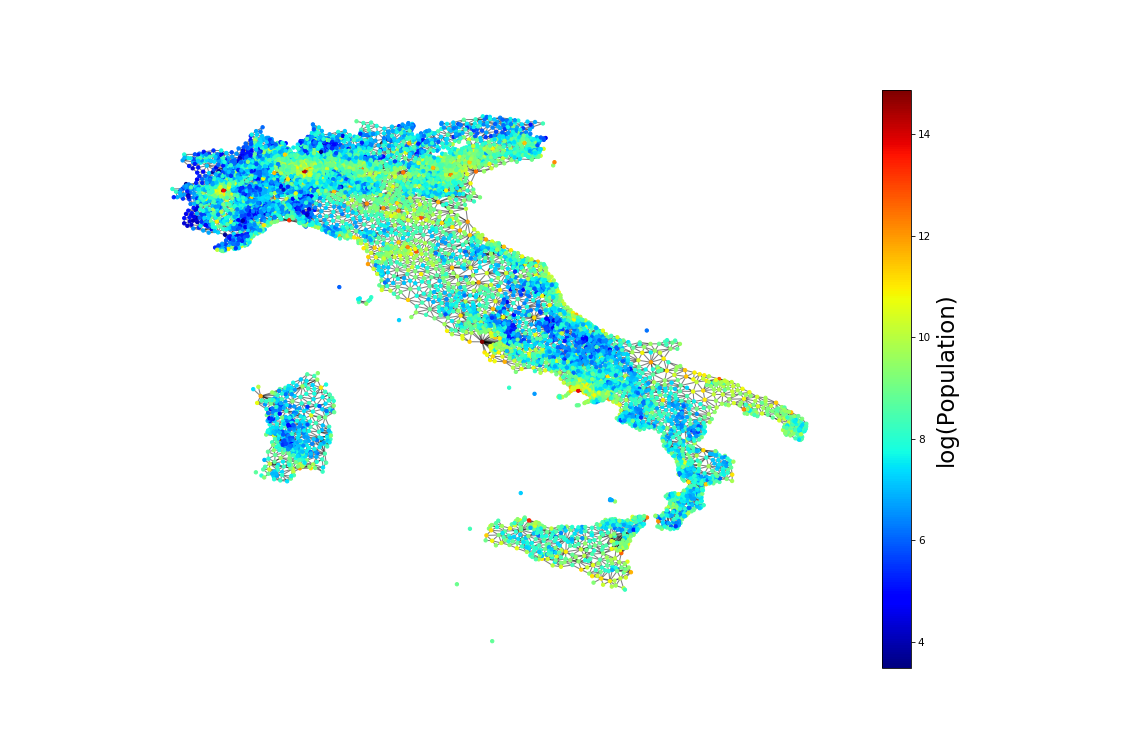

In [305]:
plt.figure(figsize=(15,10))

s=nx.draw_networkx_nodes(graph,
            pos,
            node_size=10.0,
            node_color= node_color,#list(pop_node.values()),#list(dict(nx.degree(graph)).values()),
            alpha=1,
            cmap=plt.cm.jet
            )

nx.draw_networkx_edges(graph, pos, alpha=0.5)

#show the colorbar on the right side
cbar=plt.colorbar(s)
cbar.ax.set_ylabel('log(Population)', size=22)

plt.axis('off')
plt.savefig("Italia_Munic_Net.jpg", dpi = 900, quality = 95)
plt.show()

## Munic Viz

<IPython.core.display.Javascript object>


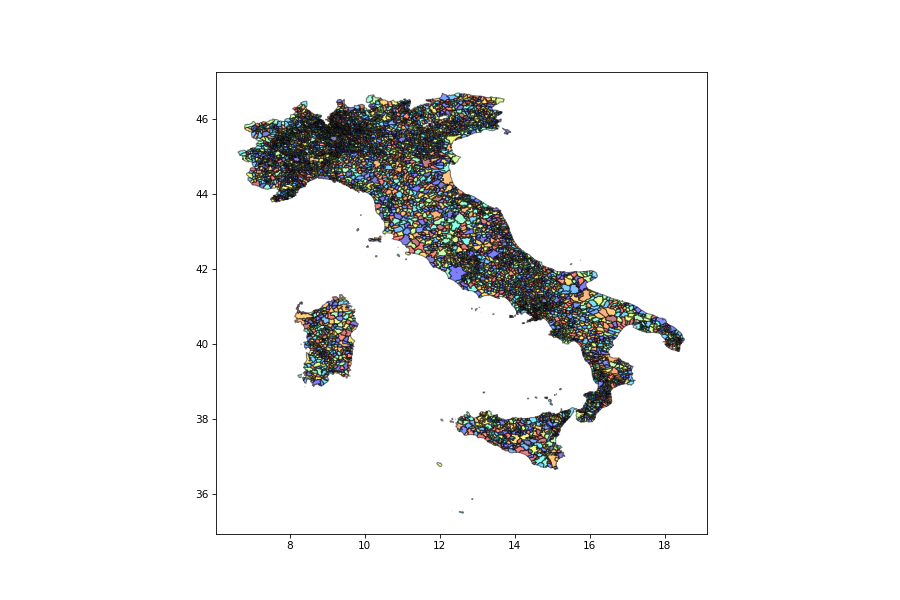

In [221]:
fig = plt.figure(figsize = (12,8)) 
ax = fig.gca() 

N = final_data.shape[0] 
nfloors = np.random.rand(N)

cmap = plt.get_cmap("jet")
colors = cmap(nfloors)

for i in range(final_data.shape[0]):
    ax.add_patch(PolygonPatch(final_data["geometry"][i],fc = colors[i], ec = 'black', alpha = 0.5))

ax.axis('scaled')
#plt.savefig("italia_open_polis.png")
plt.show()
#files.download("italia_open_polis.png")